# MNIST 손글씨 숫자 분류 튜토리얼

이 노트북에서는 PyTorch를 사용하여 MNIST 데이터셋의 손글씨 숫자를 분류하는 간단한 Multi-Layer Perceptron (MLP) 모델을 구현합니다.

## 학습 목표
1. PyTorch를 이용한 기본적인 신경망 구현
2. 데이터 로딩 및 전처리 과정 이해
3. 모델 훈련 및 평가 과정 체험
4. 예측 결과 시각화 및 분석

## 데이터셋 정보
- **MNIST**: 28x28 픽셀의 흑백 손글씨 숫자 이미지 (0-9)
- **훈련 데이터**: 60,000개
- **테스트 데이터**: 10,000개

## 1. 라이브러리 임포트

먼저 필요한 라이브러리들을 임포트합니다:

- **torch**: PyTorch의 핵심 라이브러리
- **torch.nn**: 신경망 레이어와 손실함수
- **torch.optim**: 최적화 알고리즘 (Adam, SGD 등)
- **torchvision.transforms**: 이미지 전처리
- **datasets**: HuggingFace 데이터셋 라이브러리
- **matplotlib**: 시각화
- **numpy**: 수치 계산

In [184]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


## 2. MLP (Multi-Layer Perceptron) 모델 정의

간단한 3층 신경망을 구현합니다:

1. **입력층**: 784개 뉴런 (28×28 픽셀을 1차원으로 펼침)
2. **은닉층**: 100개 뉴런 + ReLU 활성화 함수
3. **출력층**: 10개 뉴런 (0-9 클래스)

### 주요 개념:
- **nn.Linear**: Fully Connected Layer (혹은 Dense Layer)
- **nn.ReLU**: ReLU 활성화 함수 (음수는 0, 양수는 그대로)
- **nn.Sequential**: 레이어들을 순차적으로 연결

In [185]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # 784 -> 100
            nn.ReLU(),                          # 활성화 함수
            nn.Linear(hidden_size, num_classes) # 100 -> 10
        )

    def forward(self, x):
        """
        순전파 함수 // forward propagation
        x: 입력 텐서 (batch_size, 784)
        return: 출력 텐서 (batch_size, 10)
        """
        return self.layers(x)

# 모델 생성 및 구조 확인
model = MLP()
print("모델 구조:")
print(model)

# 파라미터 개수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n총 파라미터 수: {total_params:,}")
print(f"학습 가능한 파라미터 수: {trainable_params:,}")

# 각 레이어별 파라미터 수 확인
print("\n레이어별 파라미터:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape} ({param.numel():,} 개)")

모델 구조:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

총 파라미터 수: 397,510
학습 가능한 파라미터 수: 397,510

레이어별 파라미터:
layers.0.weight: torch.Size([500, 784]) (392,000 개)
layers.0.bias: torch.Size([500]) (500 개)
layers.2.weight: torch.Size([10, 500]) (5,000 개)
layers.2.bias: torch.Size([10]) (10 개)


## 3. 데이터 로딩 및 전처리

### 3.1 하이퍼파라미터 설정

먼저 학습에 사용할 하이퍼파라미터들을 정의합니다:

- **batch_size**: 한 번에 처리할 데이터의 개수
- **learning_rate**: 학습률 (너무 크면 발산, 너무 작으면 학습이 느림)
- **epochs**: 전체 데이터셋을 몇 번 반복할지

In [186]:
# 하이퍼파라미터 설정
batch_size = 128        # 배치 크기
test_batch_size = 1000  # 테스트 배치 크기 (메모리 효율을 위해 크게 설정)
learning_rate = 1e-3    # 학습률 (0.001)
nb_epochs = 15           # 에포크 수

print("=== 하이퍼파라미터 ===")
print(f"배치 크기: {batch_size}")
print(f"테스트 배치 크기: {test_batch_size}")
print(f"학습률: {learning_rate}")
print(f"에포크 수: {nb_epochs}")

# 디바이스 설정 (GPU가 있으면 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n사용 디바이스: {device}")
if device.type == "cuda":
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

=== 하이퍼파라미터 ===
배치 크기: 128
테스트 배치 크기: 1000
학습률: 0.001
에포크 수: 15

사용 디바이스: cuda
GPU 이름: Tesla T4
GPU 메모리: 14 GB


### 3.2 MNIST 데이터셋 로딩

HuggingFace datasets 라이브러리를 사용하여 MNIST 데이터를 로드합니다.

In [187]:
# MNIST 데이터셋 로딩
print("MNIST 데이터셋을 다운로드 중...")
mnist = load_dataset("mnist")

# 데이터셋 정보 출력
print("\n=== 데이터셋 정보 ===")
print(f"훈련 데이터: {len(mnist['train']):,}개")
print(f"테스트 데이터: {len(mnist['test']):,}개")
print(f"클래스 수: {len(set(mnist['train']['label']))}개 (0-9)")
print(f"이미지 크기: {mnist['train'][0]['image'].size}")

# 샘플 이미지 확인
sample_image = mnist['train'][0]['image']
sample_label = mnist['train'][0]['label']
print(f"\n첫 번째 샘플: 라벨 {sample_label}")

# 클래스별 개수 확인
from collections import Counter
label_counts = Counter(mnist['train']['label'])
print("\n클래스별 데이터 개수:")
for i in range(10):
    print(f"숫자 {i}: {label_counts[i]:,}개")

MNIST 데이터셋을 다운로드 중...

=== 데이터셋 정보 ===
훈련 데이터: 60,000개
테스트 데이터: 10,000개
클래스 수: 10개 (0-9)
이미지 크기: (28, 28)

첫 번째 샘플: 라벨 5

클래스별 데이터 개수:
숫자 0: 5,923개
숫자 1: 6,742개
숫자 2: 5,958개
숫자 3: 6,131개
숫자 4: 5,842개
숫자 5: 5,421개
숫자 6: 5,918개
숫자 7: 6,265개
숫자 8: 5,851개
숫자 9: 5,949개


### 3.3 샘플 데이터 시각화

학습하기 전에 데이터가 어떻게 생겼는지 확인해보겠습니다.

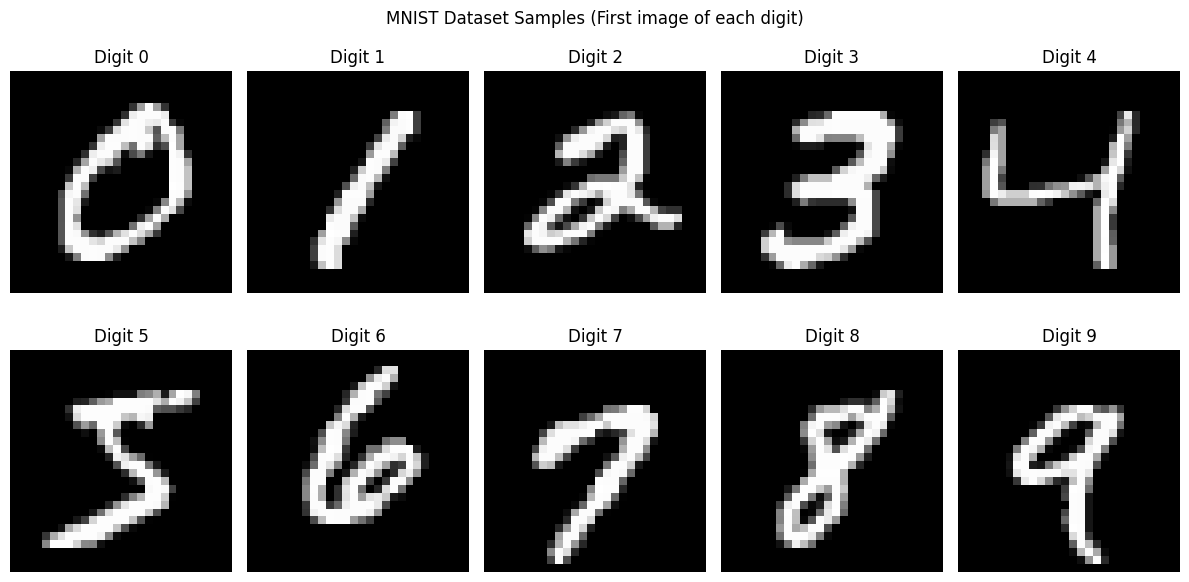

In [188]:
# 샘플 이미지들 시각화
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    # 각 숫자(0-9)에 대해 첫 번째 샘플 찾기
    for j, label in enumerate(mnist['train']['label']):
        if label == i:
            image = mnist['train'][j]['image']
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f'Digit {i}')
            axes[i].axis('off')
            break

plt.tight_layout()
plt.suptitle('MNIST Dataset Samples (First image of each digit)', y=1.02)
plt.show()

### 3.4 데이터 정규화 (Normalization)

신경망의 학습을 안정화하기 위해 픽셀 값을 정규화합니다:
1. 픽셀 값을 0-1 범위로 변환 (ToTensor())
2. 평균과 표준편차를 이용해 정규화 (Normalize())

정규화 공식: `(픽셀값 - 평균) / 표준편차`

In [189]:
# 데이터셋의 평균과 표준편차 계산 (1000개 샘플로 추정)
print("데이터셋의 통계 정보를 계산 중...")
sample_data = torch.stack([
    transforms.ToTensor()(mnist['train'][i]['image'])
    for i in range(1000)
])

mean = sample_data.mean().item()
std = sample_data.std().item()
print(f"평균(mean): {mean:.4f}")
print(f"표준편차(std): {std:.4f}")

# Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),           # PIL Image -> Tensor, 0-255 -> 0-1
    transforms.Normalize((mean,), (std,))  # 정규화
])

print("\n변환 파이프라인:")
print("1. ToTensor(): PIL Image -> PyTorch Tensor (0-255 -> 0-1)")
print(f"2. Normalize(): (픽셀값 - {mean:.4f}) / {std:.4f}")

# 변환 전후 비교
original_pixel = mnist['train'][0]['image']
transformed = transform(original_pixel)
print(f"\n변환 예시:")
print(f"원본 픽셀 범위: 0-255")
print(f"ToTensor 후: 0-1")
print(f"정규화 후 범위: 약 {transformed.min():.2f} ~ {transformed.max():.2f}")

데이터셋의 통계 정보를 계산 중...
평균(mean): 0.1282
표준편차(std): 0.3051

변환 파이프라인:
1. ToTensor(): PIL Image -> PyTorch Tensor (0-255 -> 0-1)
2. Normalize(): (픽셀값 - 0.1282) / 0.3051

변환 예시:
원본 픽셀 범위: 0-255
ToTensor 후: 0-1
정규화 후 범위: 약 -0.42 ~ 2.86


### 3.5 DataLoader 생성

DataLoader는 데이터를 배치 단위로 불러오고, 셔플링 등의 기능을 제공합니다.

In [190]:
# 데이터 변환 함수 정의
def transform_dataset(dataset):
    """데이터셋에 변환을 적용하는 함수"""
    def transform_fn(batch):
        # 이미지를 텐서로 변환하고 28x28을 784로 평탄화
        images = [transform(img).view(-1) for img in batch["image"]]
        return {
            "image": torch.stack(images),
            "label": torch.tensor(batch["label"])
        }
    return dataset.with_transform(transform_fn)

# 훈련/테스트 데이터셋에 변환 적용
print("데이터셋 변환 중...")
train_dataset = transform_dataset(mnist["train"])
test_dataset = transform_dataset(mnist["test"])

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True  # 훈련 데이터는 섞기
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False  # 테스트 데이터는 순서 유지
)

print(f"훈련 DataLoader: {len(train_loader)}개 배치")
print(f"테스트 DataLoader: {len(test_loader)}개 배치")
print(f"배치당 훈련 샘플: {batch_size}개")
print(f"배치당 테스트 샘플: {test_batch_size}개")

# 첫 번째 배치 확인
sample_batch = next(iter(train_loader))
print(f"\n첫 번째 배치 shape:")
print(f"이미지: {sample_batch['image'].shape}  # (batch_size, 784)")
print(f"라벨: {sample_batch['label'].shape}    # (batch_size,)")

데이터셋 변환 중...
훈련 DataLoader: 469개 배치
테스트 DataLoader: 10개 배치
배치당 훈련 샘플: 128개
배치당 테스트 샘플: 1000개

첫 번째 배치 shape:
이미지: torch.Size([128, 784])  # (batch_size, 784)
라벨: torch.Size([128])    # (batch_size,)


## 4. 모델 훈련

### 4.1 모델, 손실함수, 최적화기 설정

In [191]:
# 모델 초기화 (이전에 생성한 model 재사용하지 않고 새로 생성)
model = MLP().to(device)  # 모델을 GPU로 이동 (있다면)

# 손실함수: 다중 클래스 분류를 위한 CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 최적화기: Adam (적응적 학습률 알고리즘)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("=== 훈련 설정 ===")
print(f"모델: {model.__class__.__name__}")
print(f"손실함수: {criterion.__class__.__name__}")
print(f"최적화기: {optimizer.__class__.__name__}")
print(f"디바이스: {device}")
print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}개")

# 훈련 설정 요약
print(f"\n=== 훈련 정보 ===")
print(f"전체 에포크: {nb_epochs}")
print(f"배치 크기: {batch_size}")
print(f"학습률: {learning_rate}")
print(f"에포크당 배치 수: {len(train_loader)}")
print(f"에포크당 훈련 샘플 수: {len(train_loader) * batch_size:,}")
print(f"전체 훈련 스텝: {nb_epochs * len(train_loader):,}")

=== 훈련 설정 ===
모델: MLP
손실함수: CrossEntropyLoss
최적화기: Adam
디바이스: cuda
모델 파라미터 수: 397,510개

=== 훈련 정보 ===
전체 에포크: 15
배치 크기: 128
학습률: 0.001
에포크당 배치 수: 469
에포크당 훈련 샘플 수: 60,032
전체 훈련 스텝: 7,035


### 4.2 훈련 루프 실행

신경망 훈련의 기본 단계:
1. **Forward Pass**: 입력 데이터를 모델에 통과시켜 예측값 계산
2. **Loss 계산**: 예측값과 실제값의 차이(오차) 계산
3. **Backward Pass**: 역전파를 통해 각 파라미터의 그래디언트 계산
4. **Parameter Update**: 최적화기를 사용해 파라미터 업데이트

In [192]:
# 훈련 과정 추적을 위한 리스트
train_losses = []
train_accuracies = []
test_accuracies = []

print("=== 훈련 시작 ===\n")

for epoch in range(nb_epochs):
    # 훈련 모드로 설정
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, batch in enumerate(train_loader):
        # 데이터를 디바이스로 이동
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 통계 업데이트
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # 100 배치마다 중간 결과 출력
        if (batch_idx + 1) % 100 == 0:
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100 * correct_train / total_train
            print(f"Epoch [{epoch+1}/{nb_epochs}], Batch [{batch_idx+1}/{len(train_loader)}]")
            print(f"  Loss: {current_loss:.4f}, Train Acc: {current_acc:.2f}%")

    # 에포크 종료 후 훈련 통계
    epoch_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_acc)

    print(f"\nEpoch [{epoch+1}/{nb_epochs}] 훈련 완료:")
    print(f"  평균 Loss: {epoch_loss:.4f}")
    print(f"  훈련 정확도: {epoch_train_acc:.2f}%")

    # 테스트 정확도 계산
    model.eval()  # 평가 모드로 설정
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for batch in test_loader:
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)
    print(f"  테스트 정확도: {test_acc:.2f}%")
    print("-" * 60)

print(f"\n=== 훈련 완료 ===")
print(f"최종 훈련 정확도: {train_accuracies[-1]:.2f}%")
print(f"최종 테스트 정확도: {test_accuracies[-1]:.2f}%")

=== 훈련 시작 ===

Epoch [1/15], Batch [100/469]
  Loss: 0.4643, Train Acc: 86.35%
Epoch [1/15], Batch [200/469]
  Loss: 0.3474, Train Acc: 89.77%
Epoch [1/15], Batch [300/469]
  Loss: 0.2872, Train Acc: 91.50%
Epoch [1/15], Batch [400/469]
  Loss: 0.2503, Train Acc: 92.57%

Epoch [1/15] 훈련 완료:
  평균 Loss: 0.2326
  훈련 정확도: 93.14%
  테스트 정확도: 96.75%
------------------------------------------------------------
Epoch [2/15], Batch [100/469]
  Loss: 0.0994, Train Acc: 96.98%
Epoch [2/15], Batch [200/469]
  Loss: 0.0959, Train Acc: 97.11%
Epoch [2/15], Batch [300/469]
  Loss: 0.0927, Train Acc: 97.17%
Epoch [2/15], Batch [400/469]
  Loss: 0.0920, Train Acc: 97.19%

Epoch [2/15] 훈련 완료:
  평균 Loss: 0.0906
  훈련 정확도: 97.25%
  테스트 정확도: 97.54%
------------------------------------------------------------
Epoch [3/15], Batch [100/469]
  Loss: 0.0581, Train Acc: 98.34%
Epoch [3/15], Batch [200/469]
  Loss: 0.0579, Train Acc: 98.29%
Epoch [3/15], Batch [300/469]
  Loss: 0.0563, Train Acc: 98.30%
Epoch [3/15

## 5. 결과 분석 및 시각화

### 5.1 훈련 과정 시각화

Loss와 정확도의 변화를 그래프로 확인해보겠습니다.

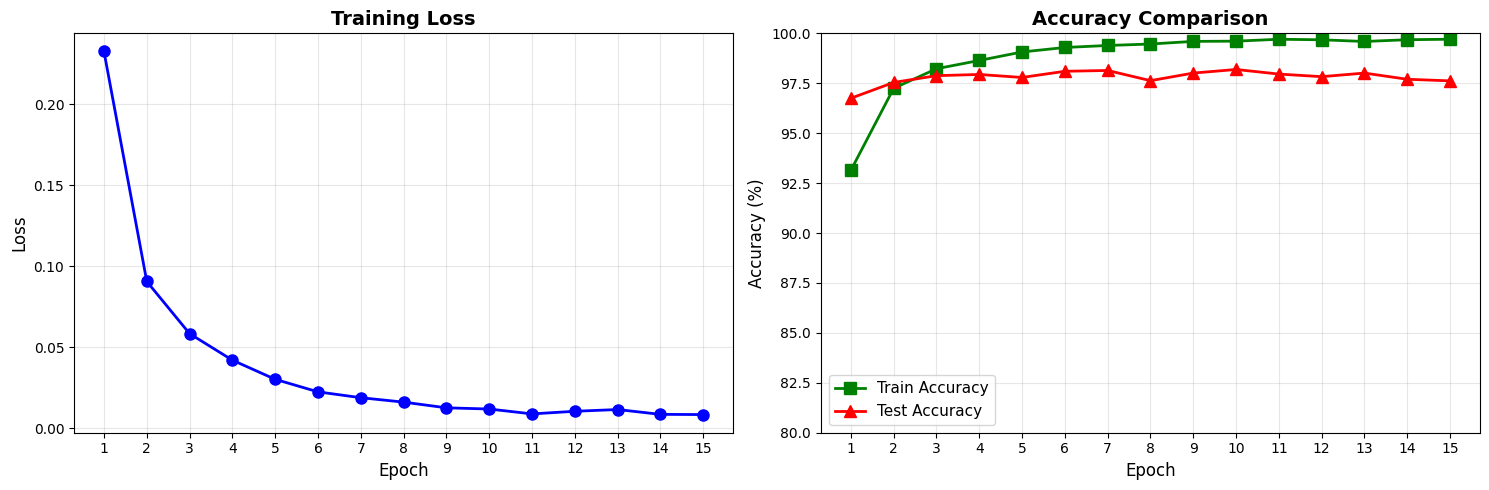

=== 최종 결과 요약 ===
최종 훈련 Loss: 0.0085
최종 훈련 정확도: 99.70%
최종 테스트 정확도: 97.62%
과적합 정도: 2.08% (훈련-테스트 정확도 차이)


In [193]:
# 훈련 과정 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss 그래프
epochs_range = range(1, nb_epochs + 1)
ax1.plot(epochs_range, train_losses, 'b-', marker='o', linewidth=2, markersize=8)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs_range)

# 정확도 그래프
ax2.plot(epochs_range, train_accuracies, 'g-', marker='s', linewidth=2,
         markersize=8, label='Train Accuracy')
ax2.plot(epochs_range, test_accuracies, 'r-', marker='^', linewidth=2,
         markersize=8, label='Test Accuracy')
ax2.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_xticks(epochs_range)
ax2.set_ylim(80, 100)

plt.tight_layout()
plt.show()

# 최종 결과 요약
print("=== 최종 결과 요약 ===")
print(f"최종 훈련 Loss: {train_losses[-1]:.4f}")
print(f"최종 훈련 정확도: {train_accuracies[-1]:.2f}%")
print(f"최종 테스트 정확도: {test_accuracies[-1]:.2f}%")
print(f"과적합 정도: {train_accuracies[-1] - test_accuracies[-1]:.2f}% (훈련-테스트 정확도 차이)")

### 5.2 예측 결과 시각화

모델이 실제로 어떻게 예측하는지 샘플 이미지들을 확인해보겠습니다. 올바른 예측과 틀린 예측을 모두 살펴보겠습니다.

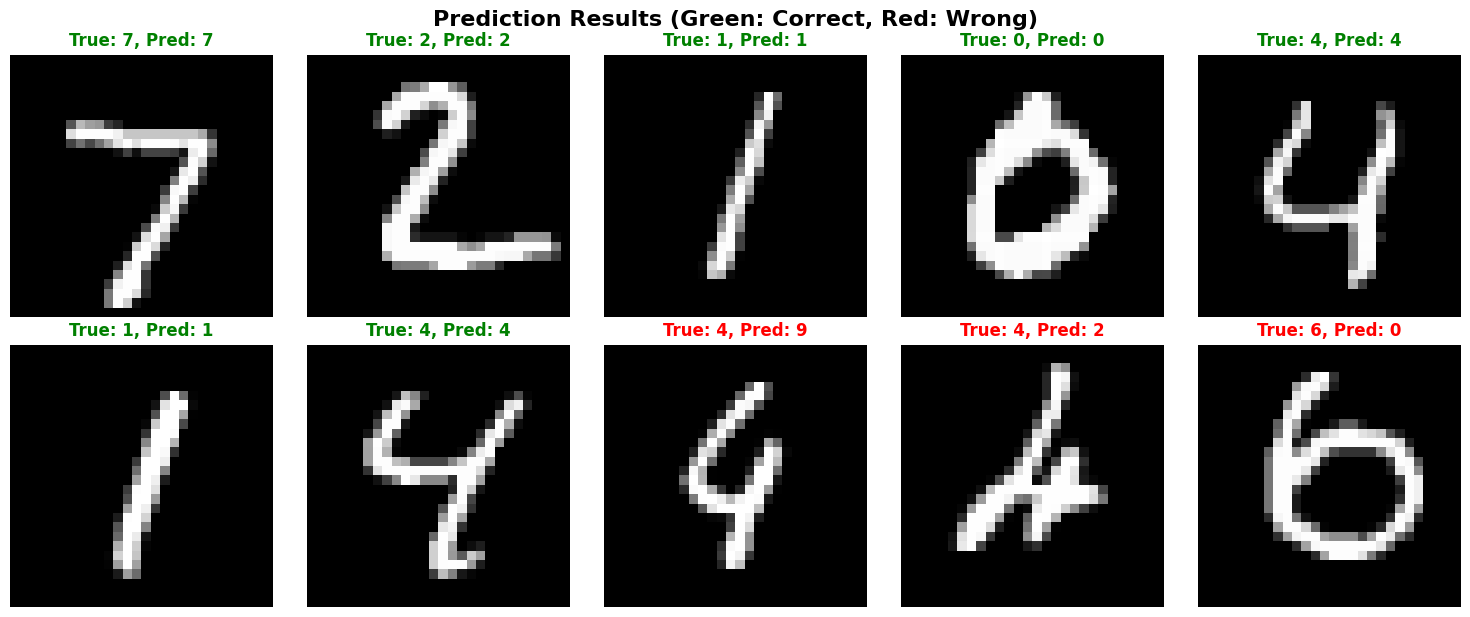

올바른 예측: 7개
틀린 예측: 3개


In [194]:
# 예측 샘플 수집
model.eval()
correct_samples = []
wrong_samples = []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        # 정확한 예측과 틀린 예측 분리
        for i in range(len(imgs)):
            if len(correct_samples) >= 7 and len(wrong_samples) >= 3:
                break

            sample = (imgs[i], labels[i], predicted[i], outputs[i])
            if labels[i] == predicted[i] and len(correct_samples) < 7:
                correct_samples.append(sample)
            elif labels[i] != predicted[i] and len(wrong_samples) < 3:
                wrong_samples.append(sample)

        if len(correct_samples) >= 7 and len(wrong_samples) >= 3:
            break

# 시각화: 7개 맞춘 것 + 3개 틀린 것
display_samples = correct_samples + wrong_samples

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (img, true_label, pred_label, output) in enumerate(display_samples):
    # 28x28로 reshape (정규화된 상태)
    img_display = img.cpu().view(28, 28)

    # 정규화를 역변환 (시각화를 위해)
    img_display = img_display * std + mean
    img_display = torch.clamp(img_display, 0, 1)

    axes[i].imshow(img_display, cmap='gray')

    # 색상 설정: 맞으면 초록, 틀리면 빨강
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label.item()}, Pred: {pred_label.item()}', color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Prediction Results (Green: Correct, Red: Wrong)', y=1.02, fontsize=16, fontweight='bold')
plt.show()

print(f"올바른 예측: {len([s for s in display_samples if s[1] == s[2]])}개")
print(f"틀린 예측: {len([s for s in display_samples if s[1] != s[2]])}개")

### 5.3 모델의 확신도 분석

틀리게 예측한 경우, 모델이 각 클래스에 대해 얼마나 확신했는지 확인해보겠습니다.

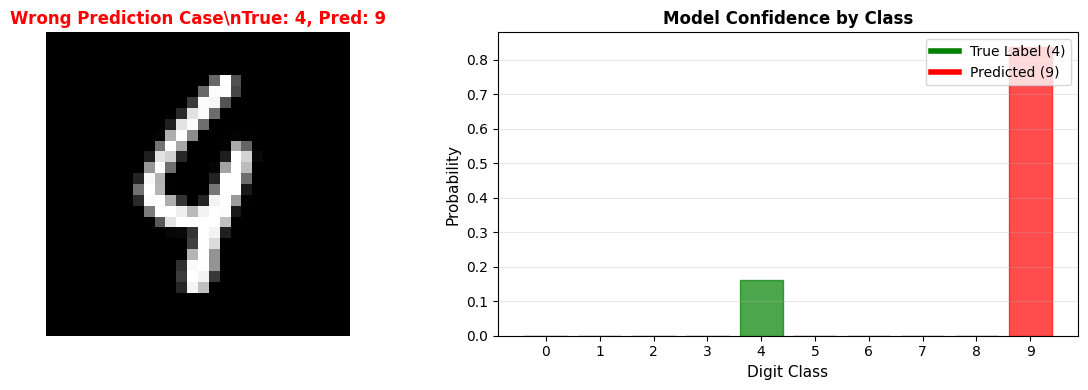

\n=== 모델의 상위 3개 예측 ===
1위: 숫자 9 (확률: 83.79%)
2위: 숫자 4 (확률: 16.18%)
3위: 숫자 5 (확률: 0.03%)
\n실제 라벨 4의 확률: 16.18%


In [195]:
# 틀린 예측에 대한 상세 분석
if wrong_samples:
    wrong_img, wrong_true, wrong_pred, wrong_output = wrong_samples[0]

    # 소프트맥스를 통해 확률로 변환
    probabilities = torch.softmax(wrong_output, dim=0).cpu()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 왼쪽: 틀린 예측 이미지
    img_display = wrong_img.cpu().view(28, 28) * std + mean
    img_display = torch.clamp(img_display, 0, 1)
    ax1.imshow(img_display, cmap='gray')
    ax1.set_title(f'Wrong Prediction Case\\nTrue: {wrong_true.item()}, Pred: {wrong_pred.item()}',
                  color='red', fontsize=12, fontweight='bold')
    ax1.axis('off')

    # 오른쪽: 확률 분포
    bars = ax2.bar(range(10), probabilities, alpha=0.7, color='lightblue', edgecolor='black')

    # 실제 라벨과 예측 라벨 강조
    bars[wrong_true.item()].set_color('green')
    bars[wrong_pred.item()].set_color('red')

    ax2.set_xlabel('Digit Class', fontsize=11)
    ax2.set_ylabel('Probability', fontsize=11)
    ax2.set_title('Model Confidence by Class', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(10))
    ax2.grid(axis='y', alpha=0.3)

    # 범례 추가
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='green', lw=4, label=f'True Label ({wrong_true.item()})'),
                       Line2D([0], [0], color='red', lw=4, label=f'Predicted ({wrong_pred.item()})')]
    ax2.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

    # 상위 3개 확률 출력
    top3_probs, top3_indices = torch.topk(probabilities, 3)
    print("\\n=== 모델의 상위 3개 예측 ===")
    for i, (prob, idx) in enumerate(zip(top3_probs, top3_indices)):
        print(f"{i+1}위: 숫자 {idx.item()} (확률: {prob.item()*100:.2f}%)")

    print(f"\\n실제 라벨 {wrong_true.item()}의 확률: {probabilities[wrong_true.item()]*100:.2f}%")

else:
    print("틀린 예측 샘플이 없습니다. 모델이 모든 테스트 샘플을 정확히 예측했습니다!")

## 6. 과제 및 실험

### 💡 학습을 위한 실험 제안

이제 기본 모델을 이해했으니, 다음과 같은 실험들을 해보세요:

#### 🔧 **Try 1: 하이퍼파라미터 튜닝**
- 학습률을 바꿔보세요 (`learning_rate = 1e-2`, `1e-4` 등)
- 은닉층 크기를 조정해보세요 (`hidden_size = 50`, `200` 등)
- 에포크 수를 늘려보세요 (`nb_epochs = 5` 또는 `10`)

#### 🏗️ **Try 2: 모델 구조 개선**
- 은닉층을 더 추가해보세요 (3층, 4층 신경망)
- 다른 활성화 함수를 시도해보세요 (`nn.Tanh()`, `nn.Sigmoid()`)
- Dropout을 추가해서 과적합을 방지해보세요

#### 📈 **Try 3: 성능 분석**
- Confusion Matrix 그리기
- 클래스별 정확도 분석
- 잘못 분류된 이미지들의 패턴 찾기

### 📝 **실험 결과 기록하기**
각 실험 후 다음을 기록해보세요:
- 최종 테스트 정확도
- 훈련 시간
- 관찰된 패턴이나 인사이트

In [196]:
# 실험을 위한 빈 셀
# 여기서 위에서 제안한 실험들을 진행해보세요!

# 예시: 학습률을 바꿔서 재훈련
# learning_rate = 1e-2  # 원래보다 10배 큰 학습률
# model = MLP().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#
# 위의 훈련 루프를 다시 실행하고 결과를 비교해보세요!

print("실험을 시작해보세요! 💪")

실험을 시작해보세요! 💪
